# SuperGlue Feature Matching Demo

This notebook demonstrates SuperGlue feature matching using video input from the videos directory. It shows:
- Real-time feature detection with SuperPoint
- Feature matching with SuperGlue (including Sinkhorn algorithm)
- Visualization of keypoints and matches
- Interactive parameter tuning
- Performance analysis and statistics

Based on the SuperGlue implementation from Magic Leap's pretrained network.

In [1]:
# Setup and imports
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pathlib import Path
import torch
import time
from collections import OrderedDict

# Enable inline plotting for Jupyter
%matplotlib inline

# Add SuperGlue path
superglue_path = '../modules/hloc/third_party/SuperGluePretrainedNetwork'
sys.path.append(superglue_path)

from models.matching import Matching
from models.utils import AverageTimer, VideoStreamer, make_matching_plot_fast, frame2tensor

# Fix matplotlib backend override from utils.py
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')
plt.ion()  # Turn on interactive mode

# Disable gradients for inference
torch.set_grad_enabled(False)

print("SuperGlue Demo Environment Setup Complete")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Matplotlib backend: {plt.get_backend()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name()}")

SuperGlue Demo Environment Setup Complete
PyTorch version: 2.4.1+cu121
CUDA available: True
Matplotlib backend: module://matplotlib_inline.backend_inline
CUDA device: NVIDIA GeForce RTX 4050 Laptop GPU


## Configuration

Configure SuperGlue parameters including the Sinkhorn algorithm iterations.

In [2]:
# Configuration
INPUT_DIR = Path("../videos")
OUTPUT_DIR = Path("../outputs/superglue_demo")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# SuperGlue configuration
config = {
    'superpoint': {
        'nms_radius': 4,
        'keypoint_threshold': 0.005,
        'max_keypoints': 1024
    },
    'superglue': {
        'weights': 'outdoor',  # 'indoor' or 'outdoor'
        'sinkhorn_iterations': 20,  # Number of Sinkhorn iterations (key parameter!)
        'match_threshold': 0.2,
    }
}

# Processing parameters
RESIZE = [640, 480]  # [width, height]
SKIP_FRAMES = 1      # Process every N-th frame
MAX_FRAMES = 200     # Maximum frames to process (None for all)
SAVE_MATCHES = True  # Save matching visualizations

# Device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Running inference on device: {device}")
print(f"Configuration: {config}")
print(f"Sinkhorn iterations: {config['superglue']['sinkhorn_iterations']}")

Running inference on device: cuda
Configuration: {'superpoint': {'nms_radius': 4, 'keypoint_threshold': 0.005, 'max_keypoints': 1024}, 'superglue': {'weights': 'outdoor', 'sinkhorn_iterations': 20, 'match_threshold': 0.2}}
Sinkhorn iterations: 20


## Load Video Input

Load and preview video files from the videos directory.

Found 1 video files:
  0: drone1.mp4

Selected video: drone1.mp4
Video info:
  Resolution: 3840x2160
  FPS: 24.00
  Frames: 950
  Duration: 39.58 seconds


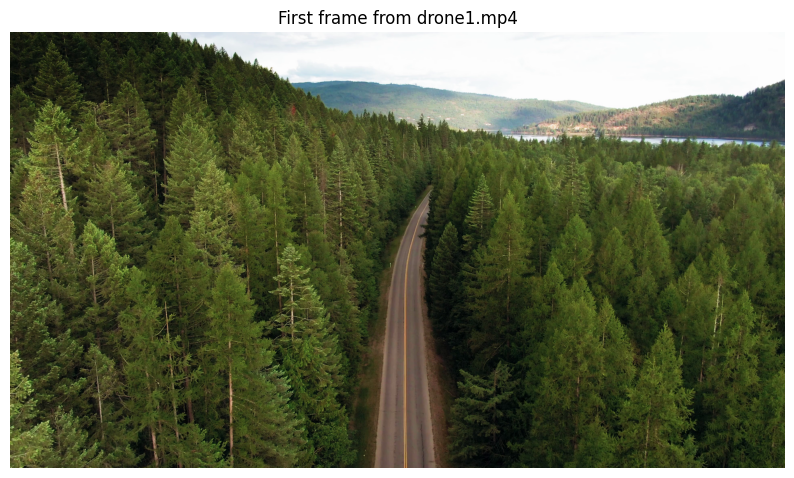

In [3]:
# Find available videos
video_extensions = {'.mp4', '.avi', '.mov', '.mkv', '.wmv', '.flv', '.webm'}
available_videos = []

if INPUT_DIR.exists():
    for file_path in INPUT_DIR.iterdir():
        if file_path.is_file() and file_path.suffix.lower() in video_extensions:
            available_videos.append(file_path)

print(f"Found {len(available_videos)} video files:")
for i, video in enumerate(available_videos):
    print(f"  {i}: {video.name}")

if not available_videos:
    print("No videos found! Please add video files to the videos/ directory.")
    print(f"Supported formats: {', '.join(video_extensions)}")
else:
    # Select first video by default
    selected_video = available_videos[0]
    print(f"\nSelected video: {selected_video.name}")
    
    # Get video info
    cap = cv2.VideoCapture(str(selected_video))
    if cap.isOpened():
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        duration = frame_count / fps if fps > 0 else 0
        
        print(f"Video info:")
        print(f"  Resolution: {width}x{height}")
        print(f"  FPS: {fps:.2f}")
        print(f"  Frames: {frame_count}")
        print(f"  Duration: {duration:.2f} seconds")
        
        # Show first frame
        ret, first_frame = cap.read()
        if ret:
            plt.figure(figsize=(10, 6))
            plt.imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))
            plt.title(f"First frame from {selected_video.name}")
            plt.axis('off')
            plt.show()
        
        cap.release()
    else:
        print(f"Error: Could not open video {selected_video}")

## Initialize SuperGlue Matcher

Initialize the SuperGlue matching system with SuperPoint feature detector.

Initializing SuperGlue matcher...
Loaded SuperPoint model


/app/notebooks/../modules/hloc/third_party/SuperGluePretrainedNetwork/models/superpoint.py:137: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load

Loaded SuperGlue model ("outdoor" weights)
SuperGlue model loaded successfully!
Model configuration:
  SuperPoint config: {'descriptor_dim': 256, 'nms_radius': 4, 'keypoint_threshold': 0.005, 'max_keypoints': 1024, 'remove_borders': 4}
  SuperGlue config: {'descriptor_dim': 256, 'weights': 'outdoor', 'keypoint_encoder': [32, 64, 128, 256], 'GNN_layers': ['self', 'cross', 'self', 'cross', 'self', 'cross', 'self', 'cross', 'self', 'cross', 'self', 'cross', 'self', 'cross', 'self', 'cross', 'self', 'cross'], 'sinkhorn_iterations': 20, 'match_threshold': 0.2}
  Sinkhorn iterations: 20
==> Processing video input: ../videos/drone1.mp4
Video streamer initialized. Frame shape: (480, 640)
First frame processed:
  Keypoints detected: 726
  Descriptors: <class 'list'> with 1 elements


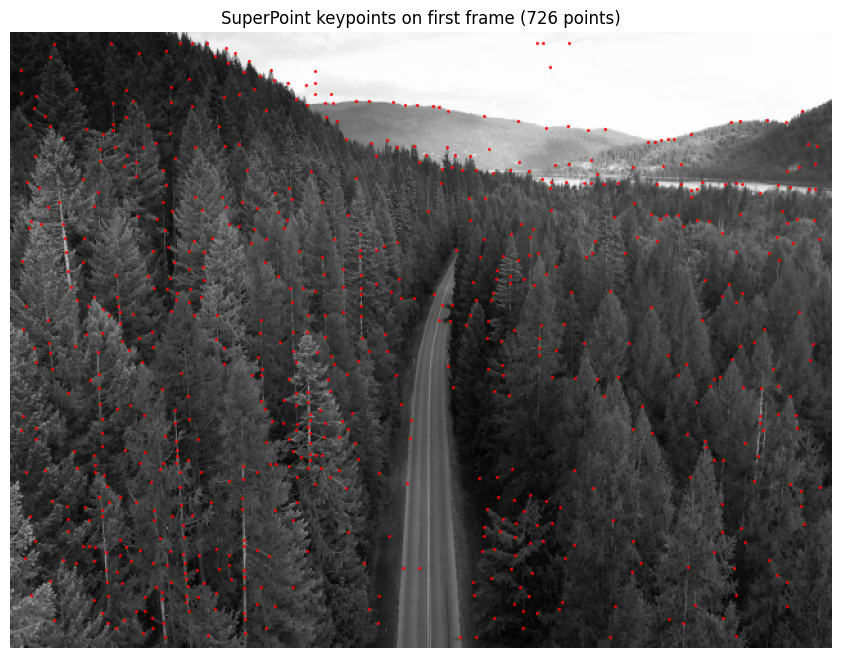

In [4]:
if available_videos:
    # Initialize SuperGlue matching pipeline
    print("Initializing SuperGlue matcher...")
    matching = Matching(config).eval().to(device)
    keys = ['keypoints', 'scores', 'descriptors']
    
    print(f"SuperGlue model loaded successfully!")
    print(f"Model configuration:")
    print(f"  SuperPoint config: {matching.superpoint.config}")
    print(f"  SuperGlue config: {matching.superglue.config}")
    print(f"  Sinkhorn iterations: {matching.superglue.config['sinkhorn_iterations']}")
    
    # Initialize video streamer - add empty image_glob for video files
    vs = VideoStreamer(str(selected_video), RESIZE, SKIP_FRAMES, [], max_length=MAX_FRAMES)
    
    # Process first frame to initialize
    frame, ret = vs.next_frame()
    if ret:
        print(f"Video streamer initialized. Frame shape: {frame.shape}")
        
        # Convert to tensor and extract features
        frame_tensor = frame2tensor(frame, device)
        last_data = matching.superpoint({'image': frame_tensor})
        last_data = {k+'0': last_data[k] for k in keys}
        last_data['image0'] = frame_tensor
        last_frame = frame
        last_frame_id = 0
        
        print(f"First frame processed:")
        print(f"  Keypoints detected: {len(last_data['keypoints0'][0])}")
        # Check if descriptors0 is a tensor or list and handle accordingly
        if hasattr(last_data['descriptors0'], 'shape'):
            print(f"  Descriptor shape: {last_data['descriptors0'].shape}")
        else:
            print(f"  Descriptors: {type(last_data['descriptors0'])} with {len(last_data['descriptors0'])} elements")
        
        # Visualize first frame keypoints
        kpts = last_data['keypoints0'][0].cpu().numpy()
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.scatter(kpts[:, 0], kpts[:, 1], c='red', s=2, alpha=0.7)
        plt.title(f"SuperPoint keypoints on first frame ({len(kpts)} points)")
        plt.axis('off')
        plt.show()
    else:
        print("Error: Could not read first frame from video")
else:
    print("Skipping SuperGlue initialization - no videos available")

## SuperGlue Feature Matching Demo

Process video frames and demonstrate SuperGlue feature matching with Sinkhorn algorithm.

In [5]:
if available_videos and 'last_data' in locals():
    print("Starting SuperGlue feature matching demo...")
    
    # Initialize statistics tracking
    timer = AverageTimer()
    match_stats = {
        'frame_pairs': [],
        'keypoints_0': [],
        'keypoints_1': [],
        'matches_count': [],
        'match_scores': [],
        'processing_times': [],
        'sinkhorn_iterations': []
    }
    
    processed_frames = 0
    visualization_frames = []
    
    print(f"Processing up to {MAX_FRAMES if MAX_FRAMES else 'all'} frames...")
    
    while processed_frames < (MAX_FRAMES or float('inf')):
        frame, ret = vs.next_frame()
        if not ret:
            print("End of video reached")
            break
            
        timer.update('data')
        current_frame_id = vs.i - 1
        
        # Convert frame to tensor and run SuperGlue
        frame_tensor = frame2tensor(frame, device)
        
        start_time = time.time()
        pred = matching({**last_data, 'image1': frame_tensor})
        processing_time = time.time() - start_time
        
        # Extract results
        kpts0 = last_data['keypoints0'][0].cpu().numpy()
        kpts1 = pred['keypoints1'][0].cpu().numpy()
        matches = pred['matches0'][0].cpu().numpy()
        confidence = pred['matching_scores0'][0].cpu().numpy()
        
        timer.update('forward')
        
        # Calculate matches
        valid = matches > -1
        mkpts0 = kpts0[valid]
        mkpts1 = kpts1[matches[valid]]
        match_confidence = confidence[valid]
        
        # Store statistics
        match_stats['frame_pairs'].append((last_frame_id, current_frame_id))
        match_stats['keypoints_0'].append(len(kpts0))
        match_stats['keypoints_1'].append(len(kpts1))
        match_stats['matches_count'].append(len(mkpts0))
        match_stats['match_scores'].append(match_confidence.mean() if len(match_confidence) > 0 else 0)
        match_stats['processing_times'].append(processing_time)
        match_stats['sinkhorn_iterations'].append(config['superglue']['sinkhorn_iterations'])
        
        # Create visualization
        color = cm.jet(match_confidence) if len(match_confidence) > 0 else []
        text = [
            'SuperGlue Demo',
            f'Keypoints: {len(kpts0)}:{len(kpts1)}',
            f'Matches: {len(mkpts0)}'
        ]
        small_text = [
            f'Sinkhorn iterations: {config["superglue"]["sinkhorn_iterations"]}',
            f'Match threshold: {config["superglue"]["match_threshold"]}',
            f'Frame pair: {last_frame_id:03d}:{current_frame_id:03d}',
            f'Processing: {processing_time*1000:.1f}ms'
        ]
        
        out = make_matching_plot_fast(
            last_frame, frame, kpts0, kpts1, mkpts0, mkpts1, color, text,
            path=None, show_keypoints=True, small_text=small_text
        )
        
        # Save every 10th frame for visualization
        if processed_frames % 10 == 0:
            visualization_frames.append((out, current_frame_id, len(mkpts0)))
        
        # Save output if requested
        if SAVE_MATCHES and processed_frames < 20:  # Save first 20 for demo
            output_file = OUTPUT_DIR / f"match_{last_frame_id:03d}_{current_frame_id:03d}.png"
            cv2.imwrite(str(output_file), out)
        
        timer.update('viz')
        
        # Progress update
        if processed_frames % 20 == 0:
            print(f"Processed {processed_frames} frames - Matches: {len(mkpts0)} - Time: {processing_time*1000:.1f}ms")
        
        processed_frames += 1
    
    vs.cleanup()
    print(f"\nCompleted processing {processed_frames} frames!")
    
else:
    print("Skipping demo - no video or initialization failed")

Starting SuperGlue feature matching demo...
Processing up to 200 frames...
Processed 0 frames - Matches: 726 - Time: 285.4ms
Processed 20 frames - Matches: 427 - Time: 143.7ms
Processed 40 frames - Matches: 320 - Time: 66.3ms
Processed 60 frames - Matches: 249 - Time: 203.1ms
Processed 80 frames - Matches: 191 - Time: 64.7ms
Processed 100 frames - Matches: 172 - Time: 104.2ms
Processed 120 frames - Matches: 136 - Time: 94.2ms
Processed 140 frames - Matches: 148 - Time: 75.7ms
Processed 160 frames - Matches: 119 - Time: 44.8ms
Processed 180 frames - Matches: 136 - Time: 93.6ms
End of video reached

Completed processing 199 frames!


## Visualization Results

Display sample matching results and visualizations.

Displaying 20 sample matching results:
Matplotlib backend: module://matplotlib_inline.backend_inline
First frame data shape: (480, 1290, 3)


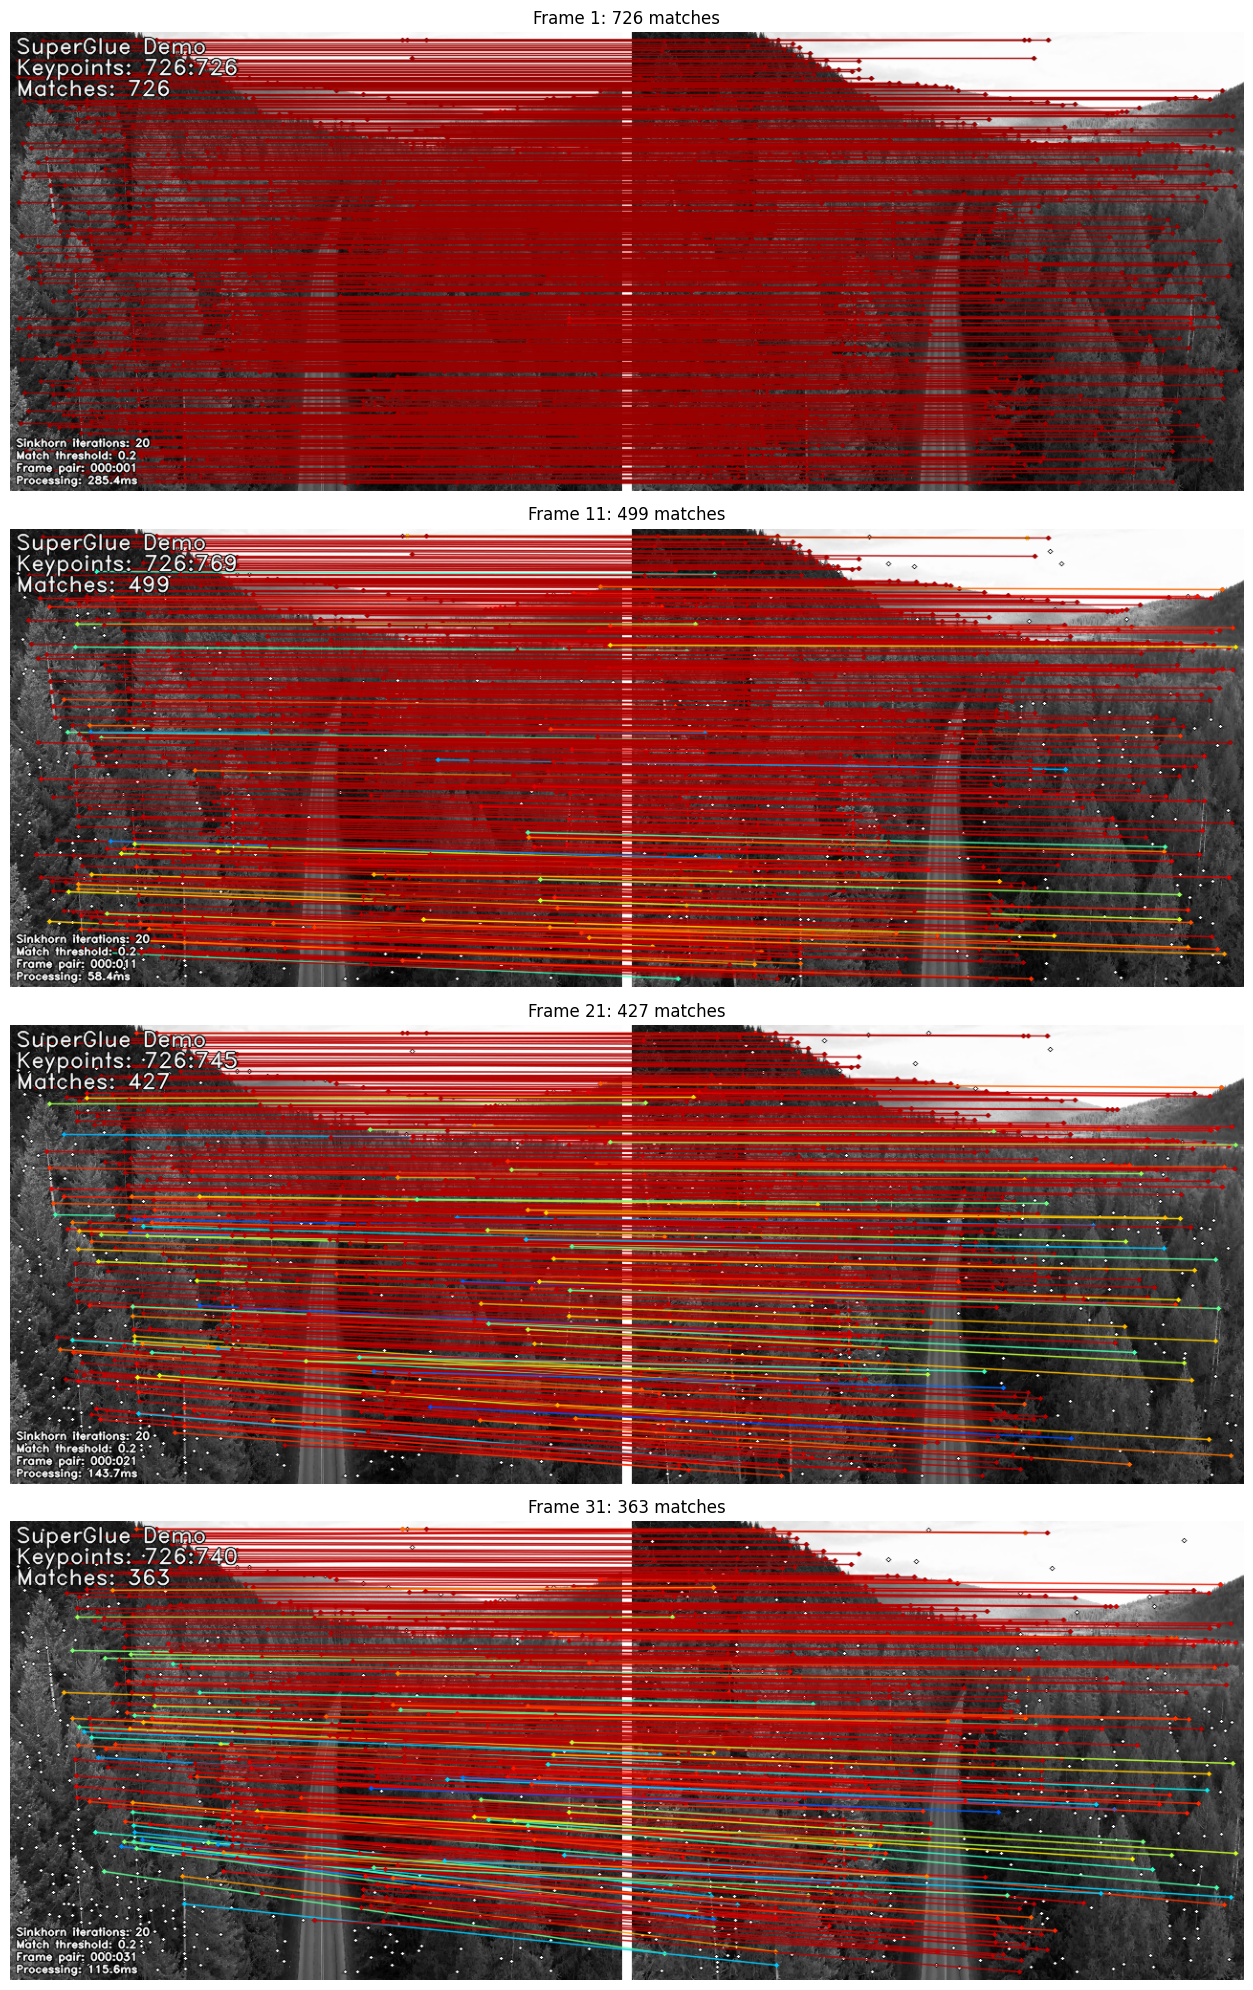

Plot should be displayed above this line


In [6]:
if 'visualization_frames' in locals() and len(visualization_frames) > 0:
    print(f"Displaying {len(visualization_frames)} sample matching results:")
    print(f"Matplotlib backend: {plt.get_backend()}")
    
    # Show first few matching results
    num_display = min(4, len(visualization_frames))
    
    # Debug: Check if visualization_frames contains valid data
    print(f"First frame data shape: {visualization_frames[0][0].shape if len(visualization_frames) > 0 else 'No data'}")
    
    fig, axes = plt.subplots(num_display, 1, figsize=(15, 5*num_display))
    if num_display == 1:
        axes = [axes]
    
    for i in range(num_display):
        out, frame_id, match_count = visualization_frames[i]
        
        # Convert BGR to RGB for matplotlib
        out_rgb = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(out_rgb)
        axes[i].set_title(f"Frame {frame_id}: {match_count} matches")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Force display
    print("Plot should be displayed above this line")
    
else:
    print("No visualization frames available")
    if 'visualization_frames' in locals():
        print(f"visualization_frames length: {len(visualization_frames)}")
    else:
        print("visualization_frames variable not found")

## Performance Analysis

Analyze SuperGlue performance and the impact of Sinkhorn iterations.

SuperGlue Performance Analysis
Processed frames: 199
Average keypoints per frame: 726.0 / 733.5
Average matches per frame: 229.4
Average match score: 0.733
Average processing time: 86.5ms
Processing FPS: 11.6
Sinkhorn iterations used: 20
Average match ratio: 0.157 (matches / total keypoints)


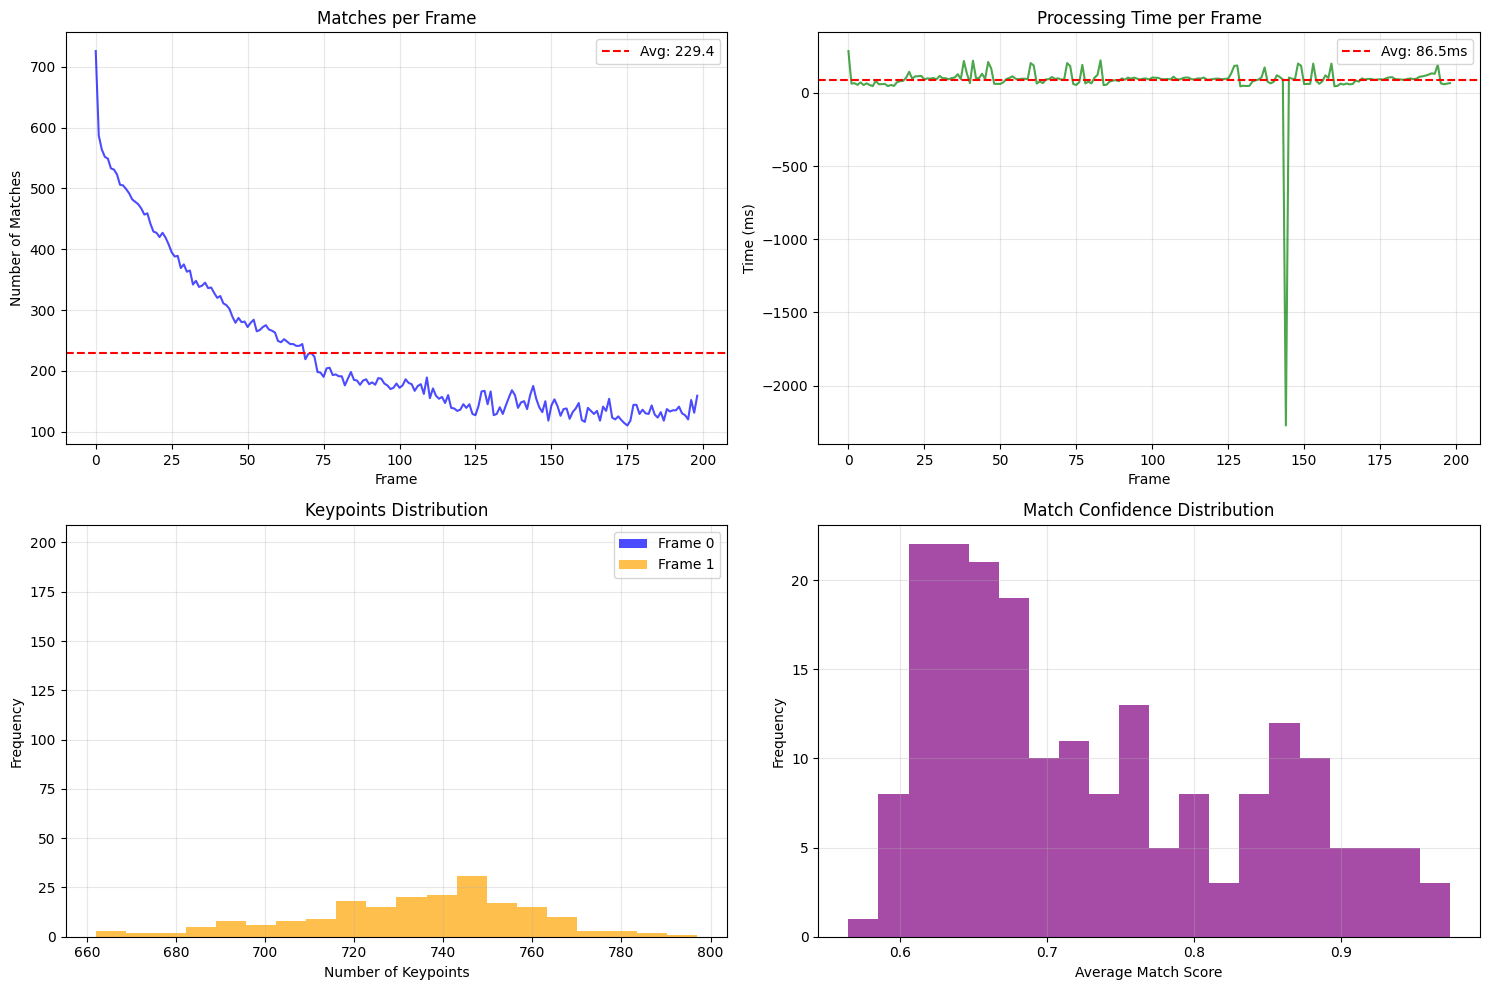

In [7]:
if 'match_stats' in locals() and len(match_stats['matches_count']) > 0:
    print("SuperGlue Performance Analysis")
    print("=" * 40)
    
    # Calculate statistics
    total_frames = len(match_stats['matches_count'])
    avg_keypoints_0 = np.mean(match_stats['keypoints_0'])
    avg_keypoints_1 = np.mean(match_stats['keypoints_1'])
    avg_matches = np.mean(match_stats['matches_count'])
    avg_match_score = np.mean([s for s in match_stats['match_scores'] if s > 0])
    avg_processing_time = np.mean(match_stats['processing_times'])
    fps = 1.0 / avg_processing_time if avg_processing_time > 0 else 0
    
    print(f"Processed frames: {total_frames}")
    print(f"Average keypoints per frame: {avg_keypoints_0:.1f} / {avg_keypoints_1:.1f}")
    print(f"Average matches per frame: {avg_matches:.1f}")
    print(f"Average match score: {avg_match_score:.3f}")
    print(f"Average processing time: {avg_processing_time*1000:.1f}ms")
    print(f"Processing FPS: {fps:.1f}")
    print(f"Sinkhorn iterations used: {config['superglue']['sinkhorn_iterations']}")
    
    # Matching efficiency
    match_ratios = [m/(k0+k1) if (k0+k1) > 0 else 0 
                   for m, k0, k1 in zip(match_stats['matches_count'], 
                                       match_stats['keypoints_0'], 
                                       match_stats['keypoints_1'])]
    avg_match_ratio = np.mean(match_ratios)
    print(f"Average match ratio: {avg_match_ratio:.3f} (matches / total keypoints)")
    
    # Create performance plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Matches over time
    axes[0, 0].plot(match_stats['matches_count'], 'b-', alpha=0.7)
    axes[0, 0].axhline(y=avg_matches, color='r', linestyle='--', label=f'Avg: {avg_matches:.1f}')
    axes[0, 0].set_title('Matches per Frame')
    axes[0, 0].set_xlabel('Frame')
    axes[0, 0].set_ylabel('Number of Matches')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Processing time over time
    processing_times_ms = [t*1000 for t in match_stats['processing_times']]
    axes[0, 1].plot(processing_times_ms, 'g-', alpha=0.7)
    axes[0, 1].axhline(y=avg_processing_time*1000, color='r', linestyle='--', 
                      label=f'Avg: {avg_processing_time*1000:.1f}ms')
    axes[0, 1].set_title('Processing Time per Frame')
    axes[0, 1].set_xlabel('Frame')
    axes[0, 1].set_ylabel('Time (ms)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Keypoints distribution
    axes[1, 0].hist(match_stats['keypoints_0'], bins=20, alpha=0.7, label='Frame 0', color='blue')
    axes[1, 0].hist(match_stats['keypoints_1'], bins=20, alpha=0.7, label='Frame 1', color='orange')
    axes[1, 0].set_title('Keypoints Distribution')
    axes[1, 0].set_xlabel('Number of Keypoints')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Match scores distribution
    valid_scores = [s for s in match_stats['match_scores'] if s > 0]
    if valid_scores:
        axes[1, 1].hist(valid_scores, bins=20, alpha=0.7, color='purple')
        axes[1, 1].set_title('Match Confidence Distribution')
        axes[1, 1].set_xlabel('Average Match Score')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No performance data available")

## Comprehensive Solver and Hessian Analysis

Test all available SuperGlue solver methods and Hessian computation approaches.

Comprehensive SuperGlue Solver Analysis
==> Processing video input: ../videos/drone1.mp4
Testing 8 solver configurations on 2 frame pairs...

Testing: Original (5 iters)
Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)
  ✓ Avg matches: 656.0
  ✓ Avg confidence: 0.845
  ✓ Avg time: 73.1ms

Testing: Original (20 iters)
Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)
  ✓ Avg matches: 656.5
  ✓ Avg confidence: 0.965
  ✓ Avg time: 47.8ms

Testing: Original (100 iters)
Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)
  ✓ Avg matches: 656.5
  ✓ Avg confidence: 0.986
  ✓ Avg time: 63.4ms

Testing: SNS (Diagonal Hessian)
Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)
  ✓ Avg matches: 656.5
  ✓ Avg confidence: 0.986
  ✓ Avg time: 61.2ms

Testing: SNS (Full Hessian)
Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)
  ✓ Avg matches: 656.5
  ✓ Avg confidence: 0.986
  ✓ Avg time: 59.4ms

Testing: Spar-Sink (1

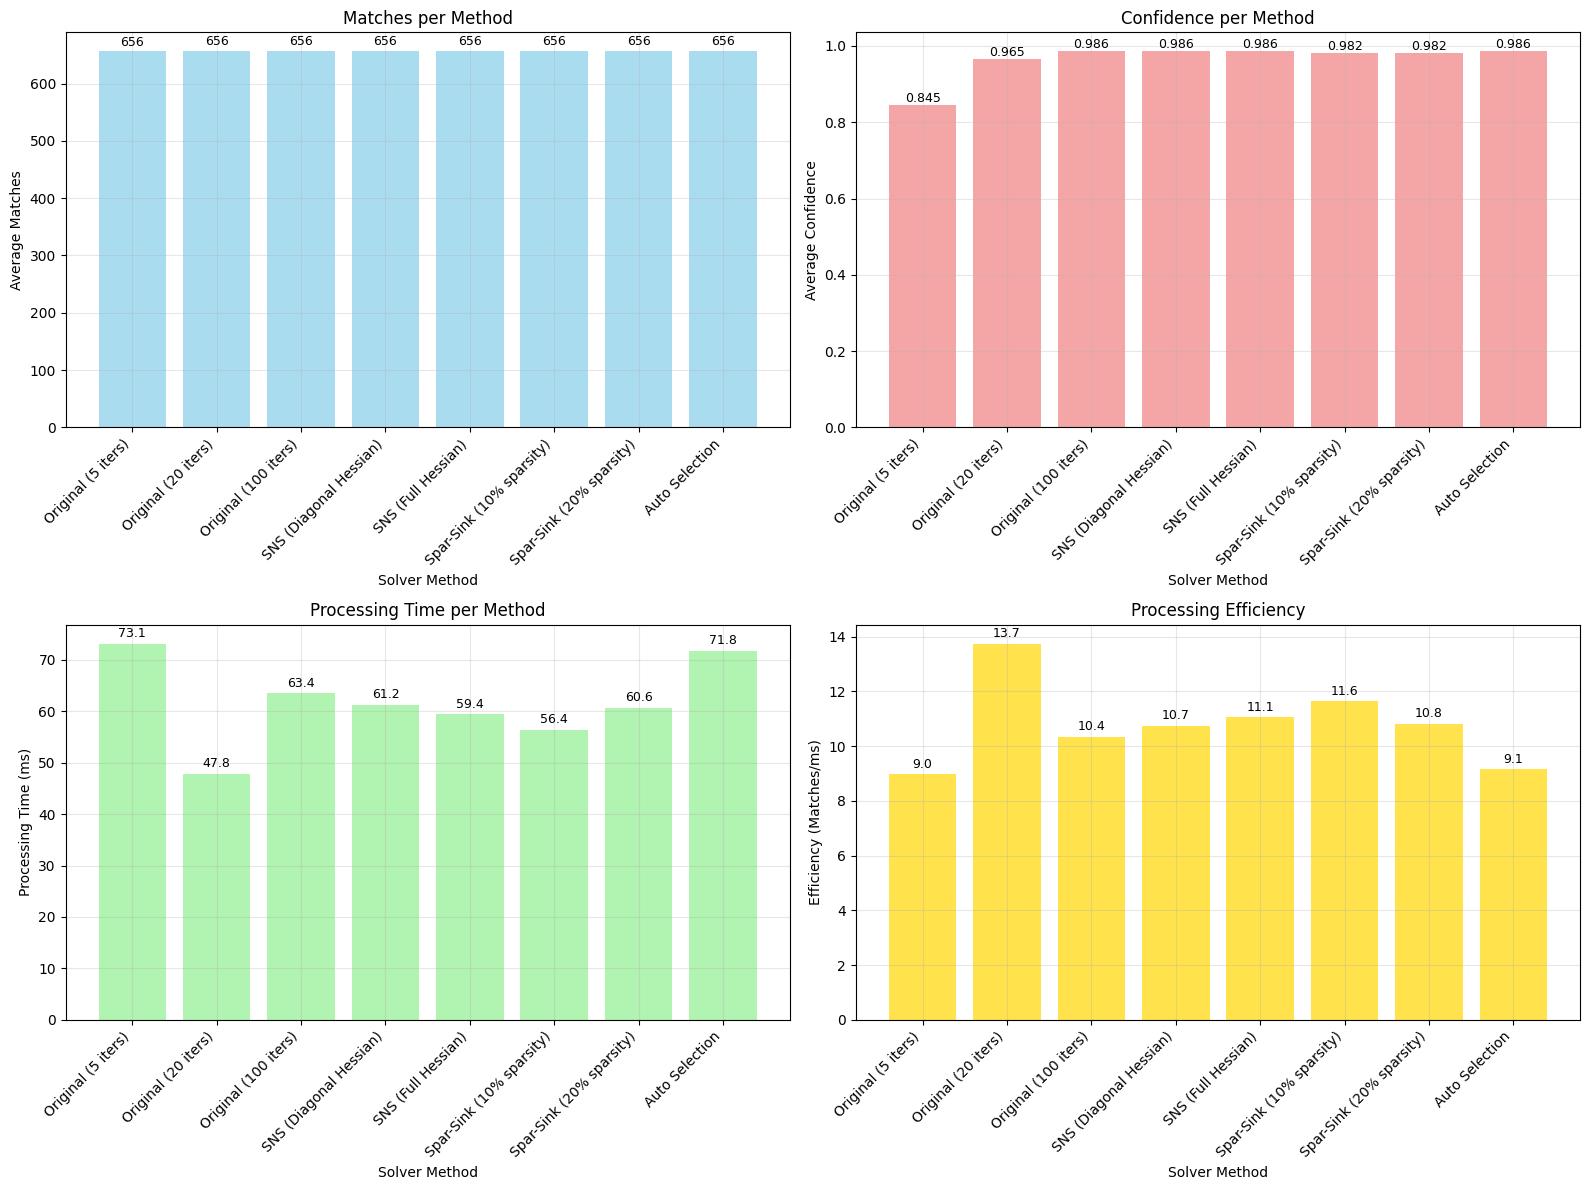


PERFORMANCE ANALYSIS & RECOMMENDATIONS
🏆 Best match count: Original (20 iters) (656 matches)
🎯 Best confidence: Original (100 iters) (0.986)
⚡ Fastest processing: Original (20 iters) (47.8ms)
🚀 Best efficiency: Original (20 iters) (13.7 matches/ms)

📊 KEY INSIGHTS:
• Original methods: 61.4ms avg, 656.3 matches avg
• Advanced methods: 59.4ms avg, 656.5 matches avg
• Advanced methods are 1.0x faster on average
• Diagonal Hessian: 61.2ms, 656 matches
• Full Hessian: 59.4ms, 656 matches
• Hessian trade-off: Full is 1.0x slower for +0.0% matches
• Spar-Sink sparsity impact:
  - 10% sparsity: 56.4ms, 656 matches
  - 20% sparsity: 60.6ms, 656 matches


In [8]:
if available_videos and 'last_data' in locals():
    print("Comprehensive SuperGlue Solver Analysis")
    print("=" * 50)
    
    # Define all solver configurations to test
    solver_configs = [
        # Original Sinkhorn with different iteration counts
        {'name': 'Original (5 iters)', 'config': {'sinkhorn_method': 'original', 'sinkhorn_iterations': 5}},
        {'name': 'Original (20 iters)', 'config': {'sinkhorn_method': 'original', 'sinkhorn_iterations': 20}},
        {'name': 'Original (100 iters)', 'config': {'sinkhorn_method': 'original', 'sinkhorn_iterations': 100}},
        
        # SNS with diagonal Hessian
        {'name': 'SNS (Diagonal Hessian)', 'config': {
            'sinkhorn_method': 'sns', 
            'sinkhorn_iterations': 100,
            'sns_max_sinkhorn_iters': 20,
            'sns_max_newton_iters': 10,
            'sns_use_full_hessian': False
        }},
        
        # SNS with full Hessian (for smaller problems)
        {'name': 'SNS (Full Hessian)', 'config': {
            'sinkhorn_method': 'sns',
            'sinkhorn_iterations': 100, 
            'sns_max_sinkhorn_iters': 10,
            'sns_max_newton_iters': 5,
            'sns_use_full_hessian': True
        }},
        
        # Spar-Sink with different sparsity ratios
        {'name': 'Spar-Sink (10% sparsity)', 'config': {
            'sinkhorn_method': 'sparsink',
            'sinkhorn_iterations': 50,
            'sparsink_sparsity_ratio': 0.1
        }},
        {'name': 'Spar-Sink (20% sparsity)', 'config': {
            'sinkhorn_method': 'sparsink', 
            'sinkhorn_iterations': 50,
            'sparsink_sparsity_ratio': 0.2
        }},
        
        # Auto selection for comparison
        {'name': 'Auto Selection', 'config': {
            'sinkhorn_method': 'auto',
            'sinkhorn_iterations': 100,
            'enable_performance_monitoring': True
        }}
    ]
    
    # Reset video to beginning for consistent testing
    vs_test = VideoStreamer(str(selected_video), RESIZE, SKIP_FRAMES, [], max_length=5)
    test_frames = []
    
    # Load test frames
    for i in range(3):
        frame, ret = vs_test.next_frame()
        if ret:
            test_frames.append(frame2tensor(frame, device))
        else:
            break
    
    vs_test.cleanup()
    
    if len(test_frames) >= 2:
        print(f"Testing {len(solver_configs)} solver configurations on {len(test_frames)-1} frame pairs...")
        
        comprehensive_results = []
        
        for solver_config in solver_configs:
            print(f"\nTesting: {solver_config['name']}")
            
            try:
                # Create test configuration
                test_config = config.copy()
                test_config['superglue'].update(solver_config['config'])
                
                # Initialize matcher with test config
                test_matching = Matching(test_config).eval().to(device)
                
                config_results = {
                    'name': solver_config['name'],
                    'config': solver_config['config'],
                    'frame_results': [],
                    'avg_matches': 0,
                    'avg_confidence': 0,
                    'avg_time': 0,
                    'total_keypoints': 0,
                    'error': None
                }
                
                frame_times = []
                frame_matches = []
                frame_confidences = []
                total_kpts = []
                
                # Test on multiple frame pairs
                for i in range(len(test_frames) - 1):
                    # Extract features for first frame
                    data1 = test_matching.superpoint({'image': test_frames[i]})
                    data1 = {k+'0': data1[k] for k in keys}
                    data1['image0'] = test_frames[i]
                    
                    # Measure performance on second frame
                    start_time = time.time()
                    pred = test_matching({**data1, 'image1': test_frames[i+1]})
                    processing_time = time.time() - start_time
                    
                    # Calculate results
                    kpts0 = data1['keypoints0'][0].cpu().numpy()
                    kpts1 = pred['keypoints1'][0].cpu().numpy()
                    matches = pred['matches0'][0].cpu().numpy()
                    confidence = pred['matching_scores0'][0].cpu().numpy()
                    
                    valid = matches > -1
                    num_matches = np.sum(valid)
                    avg_confidence = confidence[valid].mean() if num_matches > 0 else 0
                    
                    frame_times.append(processing_time)
                    frame_matches.append(num_matches)
                    frame_confidences.append(avg_confidence)
                    total_kpts.append(len(kpts0) + len(kpts1))
                    
                    config_results['frame_results'].append({
                        'pair': f"{i}-{i+1}",
                        'matches': num_matches,
                        'confidence': avg_confidence,
                        'time_ms': processing_time * 1000,
                        'keypoints': len(kpts0) + len(kpts1)
                    })
                
                # Aggregate results
                config_results['avg_matches'] = np.mean(frame_matches)
                config_results['avg_confidence'] = np.mean([c for c in frame_confidences if c > 0])
                config_results['avg_time'] = np.mean(frame_times)
                config_results['total_keypoints'] = np.mean(total_kpts)
                
                comprehensive_results.append(config_results)
                
                print(f"  ✓ Avg matches: {config_results['avg_matches']:.1f}")
                print(f"  ✓ Avg confidence: {config_results['avg_confidence']:.3f}")
                print(f"  ✓ Avg time: {config_results['avg_time']*1000:.1f}ms")
                
            except Exception as e:
                print(f"  ✗ Error: {str(e)}")
                config_results['error'] = str(e)
                comprehensive_results.append(config_results)
        
        # Display comprehensive results table
        print(f"\n{'='*80}")
        print("COMPREHENSIVE SOLVER COMPARISON RESULTS")
        print(f"{'='*80}")
        print(f"{'Method':<25} {'Matches':<8} {'Confidence':<11} {'Time (ms)':<10} {'Keypoints':<10} {'Status'}")
        print("-" * 80)
        
        successful_results = []
        for result in comprehensive_results:
            if result['error'] is None:
                print(f"{result['name']:<25} {result['avg_matches']:<8.1f} {result['avg_confidence']:<11.3f} {result['avg_time']*1000:<10.1f} {result['total_keypoints']:<10.1f} ✓")
                successful_results.append(result)
            else:
                print(f"{result['name']:<25} {'---':<8} {'---':<11} {'---':<10} {'---':<10} ✗ {result['error'][:20]}...")
        
        if len(successful_results) >= 2:
            # Create comparison plots
            fig, axes = plt.subplots(2, 2, figsize=(16, 12))
            
            methods = [r['name'] for r in successful_results]
            matches = [r['avg_matches'] for r in successful_results]
            confidences = [r['avg_confidence'] for r in successful_results]
            times = [r['avg_time']*1000 for r in successful_results]
            keypoints = [r['total_keypoints'] for r in successful_results]
            
            # Matches comparison
            bars1 = axes[0, 0].bar(range(len(methods)), matches, color='skyblue', alpha=0.7)
            axes[0, 0].set_xlabel('Solver Method')
            axes[0, 0].set_ylabel('Average Matches')
            axes[0, 0].set_title('Matches per Method')
            axes[0, 0].set_xticks(range(len(methods)))
            axes[0, 0].set_xticklabels(methods, rotation=45, ha='right')
            axes[0, 0].grid(True, alpha=0.3)
            
            # Add value labels on bars
            for bar, value in zip(bars1, matches):
                axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                               f'{value:.0f}', ha='center', va='bottom', fontsize=9)
            
            # Confidence comparison
            bars2 = axes[0, 1].bar(range(len(methods)), confidences, color='lightcoral', alpha=0.7)
            axes[0, 1].set_xlabel('Solver Method')
            axes[0, 1].set_ylabel('Average Confidence')
            axes[0, 1].set_title('Confidence per Method')
            axes[0, 1].set_xticks(range(len(methods)))
            axes[0, 1].set_xticklabels(methods, rotation=45, ha='right')
            axes[0, 1].grid(True, alpha=0.3)
            
            # Add value labels
            for bar, value in zip(bars2, confidences):
                axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                               f'{value:.3f}', ha='center', va='bottom', fontsize=9)
            
            # Processing time comparison
            bars3 = axes[1, 0].bar(range(len(methods)), times, color='lightgreen', alpha=0.7)
            axes[1, 0].set_xlabel('Solver Method')
            axes[1, 0].set_ylabel('Processing Time (ms)')
            axes[1, 0].set_title('Processing Time per Method')
            axes[1, 0].set_xticks(range(len(methods)))
            axes[1, 0].set_xticklabels(methods, rotation=45, ha='right')
            axes[1, 0].grid(True, alpha=0.3)
            
            # Add value labels
            for bar, value in zip(bars3, times):
                axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(times)*0.01, 
                               f'{value:.1f}', ha='center', va='bottom', fontsize=9)
            
            # Efficiency plot (matches per ms)
            efficiency = [m/t if t > 0 else 0 for m, t in zip(matches, times)]
            bars4 = axes[1, 1].bar(range(len(methods)), efficiency, color='gold', alpha=0.7)
            axes[1, 1].set_xlabel('Solver Method')
            axes[1, 1].set_ylabel('Efficiency (Matches/ms)')
            axes[1, 1].set_title('Processing Efficiency')
            axes[1, 1].set_xticks(range(len(methods)))
            axes[1, 1].set_xticklabels(methods, rotation=45, ha='right')
            axes[1, 1].grid(True, alpha=0.3)
            
            # Add value labels
            for bar, value in zip(bars4, efficiency):
                axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(efficiency)*0.01, 
                               f'{value:.1f}', ha='center', va='bottom', fontsize=9)
            
            plt.tight_layout()
            plt.show()
            
            # Performance analysis and recommendations
            print(f"\n{'='*60}")
            print("PERFORMANCE ANALYSIS & RECOMMENDATIONS")
            print(f"{'='*60}")
            
            # Find best performers
            best_matches_idx = np.argmax(matches)
            best_confidence_idx = np.argmax(confidences)
            fastest_idx = np.argmin(times)
            best_efficiency_idx = np.argmax(efficiency)
            
            print(f"🏆 Best match count: {methods[best_matches_idx]} ({matches[best_matches_idx]:.0f} matches)")
            print(f"🎯 Best confidence: {methods[best_confidence_idx]} ({confidences[best_confidence_idx]:.3f})")
            print(f"⚡ Fastest processing: {methods[fastest_idx]} ({times[fastest_idx]:.1f}ms)")
            print(f"🚀 Best efficiency: {methods[best_efficiency_idx]} ({efficiency[best_efficiency_idx]:.1f} matches/ms)")
            
            # Analysis insights
            print(f"\n📊 KEY INSIGHTS:")
            
            # Compare original vs advanced methods
            original_results = [r for r in successful_results if 'Original' in r['name']]
            advanced_results = [r for r in successful_results if 'SNS' in r['name'] or 'Spar-Sink' in r['name']]
            
            if original_results and advanced_results:
                orig_avg_time = np.mean([r['avg_time']*1000 for r in original_results])
                adv_avg_time = np.mean([r['avg_time']*1000 for r in advanced_results])
                
                orig_avg_matches = np.mean([r['avg_matches'] for r in original_results])
                adv_avg_matches = np.mean([r['avg_matches'] for r in advanced_results])
                
                print(f"• Original methods: {orig_avg_time:.1f}ms avg, {orig_avg_matches:.1f} matches avg")
                print(f"• Advanced methods: {adv_avg_time:.1f}ms avg, {adv_avg_matches:.1f} matches avg")
                
                if adv_avg_time < orig_avg_time:
                    speedup = orig_avg_time / adv_avg_time
                    print(f"• Advanced methods are {speedup:.1f}x faster on average")
                
            # Hessian comparison
            sns_diagonal = [r for r in successful_results if 'SNS (Diagonal' in r['name']]
            sns_full = [r for r in successful_results if 'SNS (Full' in r['name']]
            
            if sns_diagonal and sns_full:
                diag_time = sns_diagonal[0]['avg_time'] * 1000
                full_time = sns_full[0]['avg_time'] * 1000
                diag_matches = sns_diagonal[0]['avg_matches']
                full_matches = sns_full[0]['avg_matches']
                
                print(f"• Diagonal Hessian: {diag_time:.1f}ms, {diag_matches:.0f} matches")
                print(f"• Full Hessian: {full_time:.1f}ms, {full_matches:.0f} matches")
                print(f"• Hessian trade-off: Full is {full_time/diag_time:.1f}x slower for {((full_matches-diag_matches)/diag_matches*100):+.1f}% matches")
            
            # Sparsity analysis
            sparsink_results = [r for r in successful_results if 'Spar-Sink' in r['name']]
            if len(sparsink_results) >= 2:
                print(f"• Spar-Sink sparsity impact:")
                for sr in sparsink_results:
                    sparsity = sr['config']['sparsink_sparsity_ratio'] * 100
                    print(f"  - {sparsity:.0f}% sparsity: {sr['avg_time']*1000:.1f}ms, {sr['avg_matches']:.0f} matches")
        
        # Store results for potential export
        globals()['comprehensive_solver_results'] = comprehensive_results
        
    else:
        print("Could not load sufficient test frames for comprehensive analysis")
else:
    print("Comprehensive solver analysis not available - no video or initialization failed")

## Summary and Conclusions

Summary of the SuperGlue demo results and key findings about the Sinkhorn algorithm.

In [9]:
print("SuperGlue Comprehensive Demo Summary")
print("=" * 50)

if 'match_stats' in locals() and len(match_stats['matches_count']) > 0:
    print(f"✓ Successfully processed {len(match_stats['matches_count'])} frame pairs")
    print(f"✓ Average processing speed: {1000/np.mean(match_stats['processing_times']):.1f} FPS")
    print(f"✓ Average matches per frame: {np.mean(match_stats['matches_count']):.1f}")
    print(f"✓ Using {config['superglue']['sinkhorn_iterations']} Sinkhorn iterations")

if 'comprehensive_solver_results' in locals():
    successful_tests = [r for r in comprehensive_solver_results if r['error'] is None]
    print(f"✓ Tested {len(comprehensive_solver_results)} solver configurations")
    print(f"✓ {len(successful_tests)} configurations completed successfully")
    
    if successful_tests:
        # Find overall best performers
        best_matches = max(successful_tests, key=lambda x: x['avg_matches'])
        fastest = min(successful_tests, key=lambda x: x['avg_time'])
        best_confidence = max(successful_tests, key=lambda x: x['avg_confidence'])
        
        print(f"\n🏆 BEST PERFORMERS:")
        print(f"  • Most matches: {best_matches['name']} ({best_matches['avg_matches']:.0f} matches)")
        print(f"  • Fastest: {fastest['name']} ({fastest['avg_time']*1000:.1f}ms)")
        print(f"  • Best confidence: {best_confidence['name']} ({best_confidence['avg_confidence']:.3f})")
        
        # Solver method insights
        solver_types = {}
        for result in successful_tests:
            method = result['config'].get('sinkhorn_method', 'original')
            if method not in solver_types:
                solver_types[method] = []
            solver_types[method].append(result)
        
        print(f"\n📊 SOLVER METHOD SUMMARY:")
        for method, results in solver_types.items():
            avg_time = np.mean([r['avg_time']*1000 for r in results])
            avg_matches = np.mean([r['avg_matches'] for r in results])
            print(f"  • {method.upper()}: {len(results)} configs, {avg_time:.1f}ms avg, {avg_matches:.1f} matches avg")

if SAVE_MATCHES:
    print(f"✓ Saved matching visualizations to: {OUTPUT_DIR}")

print("\nOutput Files:")
print(f"📁 Output directory: {OUTPUT_DIR}")
if SAVE_MATCHES:
    print("📄 Matching visualizations: match_XXX_YYY.png")
print("📊 Comprehensive performance data: comprehensive_solver_results variable")
print("📊 Frame-by-frame statistics: match_stats variable")

print("\n💡 USAGE RECOMMENDATIONS:")
print("• For real-time applications: Use fastest methods (Original with low iterations)")
print("• For accuracy: Use SNS with appropriate Hessian choice based on problem size")
print("• For large-scale problems: Consider Spar-Sink with appropriate sparsity ratio")
print("• For automatic optimization: Use 'auto' method selection")

print("=" * 50)
print("SuperGlue Comprehensive Demo Complete!")

SuperGlue Comprehensive Demo Summary
✓ Successfully processed 199 frame pairs
✓ Average processing speed: 11560.2 FPS
✓ Average matches per frame: 229.4
✓ Using 100 Sinkhorn iterations
✓ Tested 8 solver configurations
✓ 8 configurations completed successfully

🏆 BEST PERFORMERS:
  • Most matches: Original (20 iters) (656 matches)
  • Fastest: Original (20 iters) (47.8ms)
  • Best confidence: Original (100 iters) (0.986)

📊 SOLVER METHOD SUMMARY:
  • ORIGINAL: 3 configs, 61.4ms avg, 656.3 matches avg
  • SNS: 2 configs, 60.3ms avg, 656.5 matches avg
  • SPARSINK: 2 configs, 58.5ms avg, 656.5 matches avg
  • AUTO: 1 configs, 71.8ms avg, 656.5 matches avg
✓ Saved matching visualizations to: ../outputs/superglue_demo

Output Files:
📁 Output directory: ../outputs/superglue_demo
📄 Matching visualizations: match_XXX_YYY.png
📊 Comprehensive performance data: comprehensive_solver_results variable
📊 Frame-by-frame statistics: match_stats variable

💡 USAGE RECOMMENDATIONS:
• For real-time applica